### Teoretiska frågor:

1. En relationsdatabas fungerar så att datan lagras i tabeller som är sammankopplade med varandra på ett ickehierarkiskt sätt. Tabellerna relaterar till varnandra genom gemensamma värden som kallas *primary keys* och *foreign keys*. Användare kan interagera med databasen genom en datbashanterare, som exempelvis MySQL eller MSSQL.

2. CRUD-flödet syftar på de grundläggande aktiviteter som användaren kan utföra med en databas:

    *Create* - Lägga in data.

    *Read* - Läsa data.

    *Update* - Ändra data.

    *Delete* - Radera data.

3. *Joins* används för att koppla samman olika tabeller. *Left join* innebär att alla värden från tabell 1 (den vänstra) kombineras med de värden som är gemensamma med tabell 2 (den högra). *Inner join* betyder att alla värden som finns i båda, och bara i båda, tas med.

4. Indexering innebär att rader grupperas under olika rubriker. Det gör att det går snabbare att hitta specifika rader genom att dela upp sökningen efter index, istället för att söka igenom alla rader en och en.

5. Beskriv kort vad en vy i SQL är.
En vy är en tillfällig tabell som definierats av en *query* och vars värden inte sparas. Istälet sparas *query*n och tabellen skapas på nytt varje gång *query*n utförs. En vy begränsar vad som visas ur databasen och är på så sätt säkrare. En vy kan dock ta mer tid då *query*n måste köras på nytt varje gång. 

6. En lagrad procedur (*stored procedure*) är sparad kod som kan återanvändas. Likt en funktion kan de ta emot parametrar och returnera värden, parametrar och dylikt.

In [31]:
# Importerar de bibliotek som behövs.
import sqlalchemy as sa
from sqlalchemy.engine import URL
from sqlalchemy import create_engine, inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Sätter upp koppling mellan MSSQL och JupyterNotebook.
SERVER = 'localhost'
DATABASE = 'AdventureWorks2022'
connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'
connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})
engine = create_engine(connection_url)

### Databasen AdventureWorks2022
AdventureWorks2022 är en fiktiv databas framtagen av Microsoft i utbildningssyfte. Företaget Adventure Works ska föreställa ett multinationellt detaljhandelsföretag baserat i USA. Databasen är relationsbaserad och organiserad i en Online Transaction Processing-struktur (OLTP).

Databasen omfattar tidsperioden från och med juni 2011 till och med juni 2014. I databasen finns data från flera delar av företaget, såsom produktion, försäljning och *Human Resources* (HR).

In [33]:
# Antal anställda som finns listade i databasen:
employeeCountQuery = """
SELECT
    COUNT(NationalIDNumber) AS EmployeeCount
FROM
    HumanResources.Employee;

"""
employeeCount = pd.read_sql(employeeCountQuery, engine)

# Antal olika typer av produkter som finns listade i databasen:
productCountQuery = """
SELECT
    COUNT(ProductID) AS ProductCount
FROM
    Production.Product;
"""
productCount = pd.read_sql(productCountQuery, engine)

employeeCountValue = employeeCount.iloc[0]['EmployeeCount']
productCountValue = productCount.iloc[0]['ProductCount']

print(f"AdventureWorks har {employeeCountValue} anställda och tillverkar {productCountValue} olika produkter.")

AdventureWorks har 290 anställda och tillverkar 504 olika produkter.


##### Kasserat material
Jag har tittat närmare på datan över kasserat material från produktionen. I databasen finns uppgifter om mängden som kasseras (ScrappedQty) och anledningen till kassering (ScrapReason).

Nedan visas ett detaljerat diagram över de tabeller jag har använt i min analys och relationen dem emellan (diagrammet är gjort i MSSQL).

![bild error](adventureWorksProductionDiagram.png)

Tabellen nedan visar en översikt över mängden kasserat material och de olika kategorier av orsaker till kassering som har registrerats.

In [34]:
# Översikt över mängden kasserat material och anledning till kassering.
scrapOverviewQuery = """
SELECT
	W.ScrapReasonID
	,SUM(W.ScrappedQty) AS TotalScrappedQty
	,S.Name AS ScrapReason
FROM Production.WorkOrder AS W
INNER JOIN
	Production.ScrapReason AS S
	ON W.ScrapReasonID = S.ScrapReasonID
INNER JOIN
	Production.Product AS P
	ON W.ProductID = P.ProductID
WHERE
	W.ScrappedQty > 0
GROUP BY
	W.ScrapReasonID, S.Name
ORDER BY
	TotalScrappedQty DESC;
"""
scrapOverview = pd.read_sql(scrapOverviewQuery, engine)
print(scrapOverview)

    ScrapReasonID  TotalScrappedQty                      ScrapReason
0               8              1271             Paint process failed
1              14               981             Trim length too long
2              13               876   Thermoform temperature too low
3               6               826             Drill size too small
4              16               804                 Wheel misaligned
5              15               763            Trim length too short
6               4               762          Drill pattern incorrect
7               9               743            Primer process failed
8              10               692     Seat assembly not as ordered
9               3               575                   Gouge in metal
10              5               506             Drill size too large
11              2               491                  Color incorrect
12              1               459    Brake assembly not as ordered
13             12               39

In [35]:
# Tar fram enheter för det kasserade materialet.
enhetsQuery = """SELECT
    U.Name AS UnitOfMeasure
    ,COUNT(*) AS Total
FROM 
    Production.WorkOrder AS W
INNER JOIN 
    Production.Product AS P
    ON W.ProductID = P.ProductID
LEFT JOIN 
    Production.UnitMeasure AS U
    ON P.SizeUnitMeasureCode = U.UnitMeasureCode
WHERE 
    W.ScrappedQty > 0
GROUP BY
	U.Name
ORDER BY Total DESC;
"""
enheter = pd.read_sql(enhetsQuery, engine)
print(enheter)

  UnitOfMeasure  Total
0          None    506
1    Centimeter    223


Tabellen ovan visar vilka enheter som det kasserade materialet har mätts i. De flesta rader med information om kasserat material har inte någon enhet registerad. Jag har jag valt att helt ignorera det och behandla datan som att allt kasserat material har samma enhet (ingen). Det blev mycket roligare så.

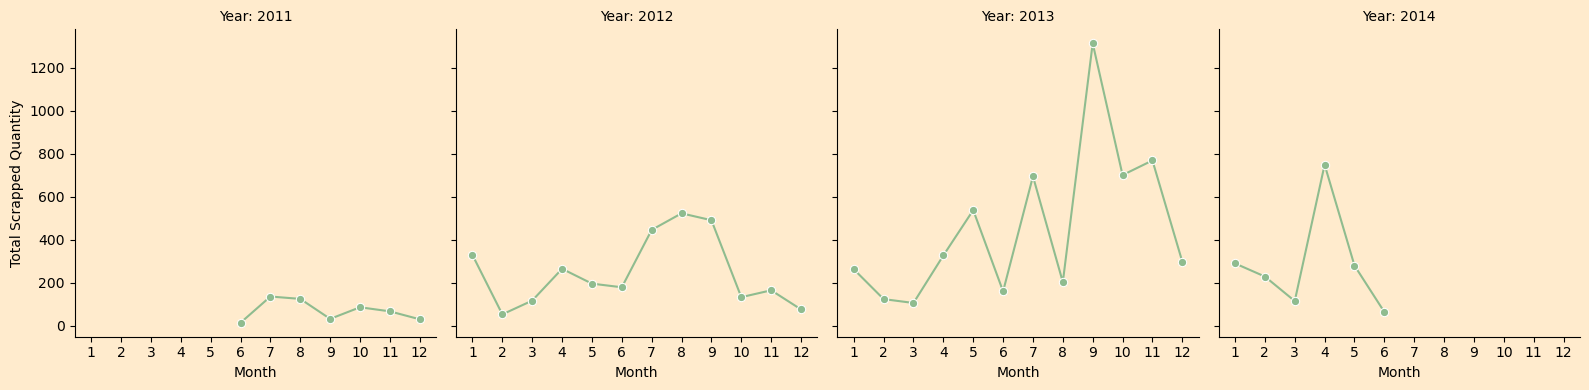

In [36]:
# Mängden kasserat material månadsvis.
scrap_monthly_query = """
SELECT
    YEAR(EndDate) AS ScrapYear
    ,MONTH(EndDate) AS ScrapMonth
    ,SUM(ScrappedQty) AS TotalScrap
FROM
    Production.WorkOrder
WHERE
    ScrappedQty > 0
GROUP BY
    YEAR(EndDate), MONTH(EndDate)
ORDER BY
    ScrapYear, ScrapMonth;
"""

scrap_data = pd.read_sql(scrap_monthly_query, engine)
scrap_data['YearMonth'] = scrap_data['ScrapYear'].astype(str) + '-' + scrap_data['ScrapMonth'].astype(str).str.zfill(2)

g = sns.FacetGrid(scrap_data, col="ScrapYear", col_wrap=4, height=4)
g.map(sns.lineplot, "ScrapMonth", "TotalScrap", color='darkseagreen', marker='o')
g.set_axis_labels("Month", "Total Scrapped Quantity")
g.set_titles("Year: {col_name}")
g.set(xticks=list(range(1, 13)))
plt.gcf().set_facecolor('blanchedalmond')
for ax in g.axes.flat:
    ax.set_facecolor('blanchedalmond')
g.tight_layout()

Diagrammen ovan visar mängden kasserat material månadsvis under tidsperioden för mätning (observera att tidsperioden är från juni 2011 till och med juni 2014). Variationen är över tid är stor och det finns en tydlig topp i september år 2013.

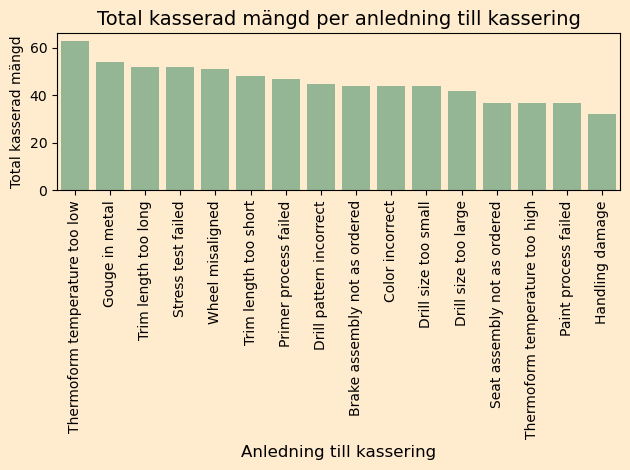

In [37]:
# Totalt antal kasserad mängd per kasseringskategori.
scrapReasonCategoriesQuery = """
SELECT
	W.ScrapReasonID
	,S.Name AS ScrapReason
	,COUNT(*) AS ScrapCount
FROM
	Production.WorkOrder AS W
INNER JOIN
	Production.ScrapReason AS S
ON W.ScrapReasonID = S.ScrapReasonID
WHERE 
	W.ScrapReasonID IS NOT NULL
GROUP BY
	W.ScrapReasonID, S.Name
ORDER BY
	ScrapCount DESC;
"""

scrapReasonCategoryTotal= pd.read_sql(scrapReasonCategoriesQuery, engine)

sns.barplot(data=scrapReasonCategoryTotal, x='ScrapReason', y='ScrapCount', color='darkseagreen')
plt.title("Total kasserad mängd per anledning till kassering", fontsize=14)
plt.xlabel("Anledning till kassering", fontsize=12)
plt.ylabel("Total kasserad mängd", fontsize=10)
plt.xticks(rotation=90)
plt.gcf().set_facecolor('blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')
plt.tight_layout()

Diagrammet ovan visar den sammanlagda mängden kasserat materal uppdelat på de olika registrerade anledningarna till kassering. Minst spill orsakas av hantering medan för låg temperatur i termoformningsprocessen orsakar flest kasseringar totalt sett.

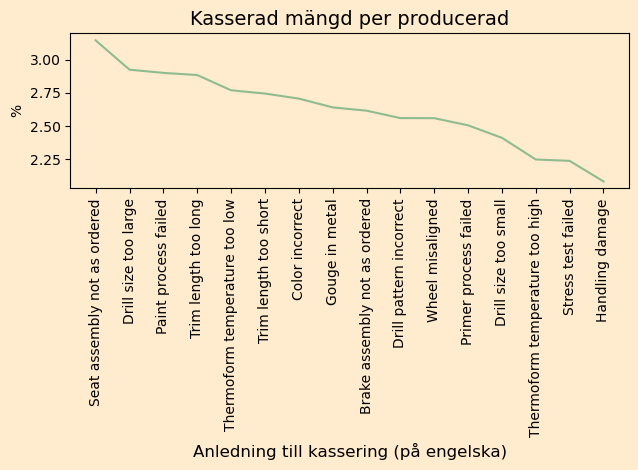

In [38]:
# Kasserad mängd jämfört med producerad (beställd) mängd, uppdelat i kasseringsanledning.
scrapToOrderRatioQuery = """
SELECT
    S.Name AS ScrapReasonName
    ,SUM(W.OrderQty) AS TotalProducedQty
    ,SUM(W.ScrappedQty) AS TotalScrappedQty
    ,(CAST(SUM(W.ScrappedQty) AS FLOAT) / NULLIF(SUM(W.OrderQty), 0)) * 100 AS ScrapPercentage
FROM
    Production.WorkOrder AS W
INNER JOIN 
    Production.ScrapReason AS S
    ON W.ScrapreasonID = S.ScrapReasonID
WHERE
    W.OrderQty > 0 AND W.ScrappedQty > 0
GROUP BY
    S.Name
ORDER BY
    ScrapPercentage DESC;
"""

scrapToOrderRatio = pd.read_sql(scrapToOrderRatioQuery, engine)

sns.lineplot(data=scrapToOrderRatio, x='ScrapReasonName', y='ScrapPercentage', color='darkseagreen')
plt.title("Kasserad mängd per producerad", fontsize=14)
plt.xlabel("Anledning till kassering (på engelska)", fontsize=12)
plt.ylabel("%", fontsize=10)
plt.xticks(rotation=90)
plt.gcf().set_facecolor('blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')
plt.tight_layout()

Ovanstående diagram illustrerar förhållandet mellan mängden materialspill och den mängd som produceras (antaget att antalet beställningar speglar produktionen, dvs att de producerar mer eller mindre *on demand*.) Montering av säte leder till mest kasserat material i relation till producerat material. Hantering orsakar minst spill även relativt till produktionen.

Termoforminorsakar relativt mycket materialspill både sett till total mängd och i relation till producerad mängd. För låg temperatur verkar vara det största problemet men för hög temperatur orsakar också en del spill.

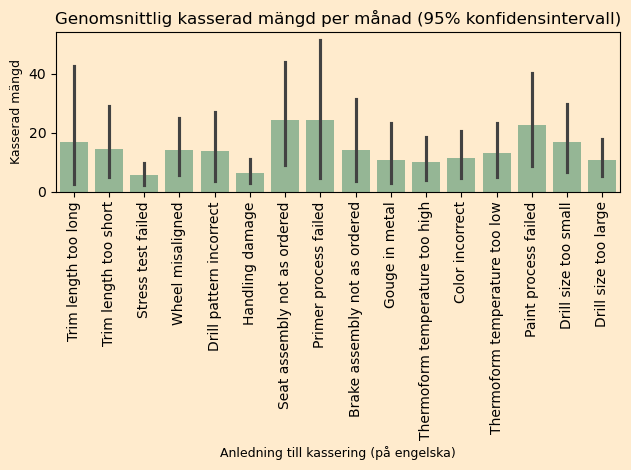

In [39]:
# Kasserat material genomssnittligt per månad och uppdelat i kasseringsanledning.
scrapReasonsMonthlyQuery = """
SELECT 
    YEAR(W.StartDate) AS ScrapYear,
    MONTH(W.StartDate) AS ScrapMonth,
    W.ScrapReasonID,
    S.Name AS ScrapReason,
    AVG(W.ScrappedQty) AS AvgScrappedQty
FROM 
    Production.WorkOrder AS W
INNER JOIN 
    Production.ScrapReason AS S
ON 
    W.ScrapReasonID = S.ScrapReasonID
WHERE 
    W.ScrapReasonID IS NOT NULL
    AND W.ScrappedQty > 0
GROUP BY 
    YEAR(W.StartDate), 
    MONTH(W.StartDate), 
    W.ScrapReasonID, 
    S.Name
ORDER BY 
    ScrapYear, ScrapMonth, AvgScrappedQty DESC;
"""

scrapReasonsMonthly = pd.read_sql(scrapReasonsMonthlyQuery, engine)

sns.barplot(data=scrapReasonsMonthly, x='ScrapReason', y='AvgScrappedQty', color='darkseagreen')
plt.title("Genomsnittlig kasserad mängd per månad (95% konfidensintervall)", fontsize=12)
plt.xlabel("Anledning till kassering (på engelska)", fontsize=9)
plt.ylabel("Kasserad mängd", fontsize=9)
plt.xticks(rotation=90)
plt.gcf().set_facecolor('blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')
plt.tight_layout()

Diagrammet ovan visar medelvärdet av mängden kasserat material per kalendermånad. De mindre strecken visualiserar ett konfidensintervall på 95%, dvs variationen i kasserad mängd kalendermånadsvis. Variationen mellan månaderna är reltivt stor inom de flesta av kategorierna. Bortsett från osäkerheter i mätningen kan det visar det på en oregelbundenhet i förekomst.

För att vidare förstå och kunna minska mängden kasserat material behövs en mer ingående undersökning i de specifika produktionsled där det sker händelser som gör att material måste kasseras. För att kunna minska spillet bör varje kasseringsanledning, det vill säga berörd led i produktionsprocessen, undersökas grundligare.

De orsaker med stort konfidensintervall (dvs stor variation) bör undersökas närmare för att se vad som orsakar den osäkerheten i produktionen. De orsaker med en liten variaton bör undersökas vidare för att se om det finns ett systematiskt fel i produktionen som kan åtgärdas.

Produktionsledet som innefattar termoformning medför en högre risk för materialspill jämfört med andra orsaker. Montering av säte renderar störst mängd materialspill per producerad mängd.

#### Sammanfattning
En betydande mängd material kasseras pga skador och felaktigheter som uppkommer i produktionen. Av de identifierade och registrerade orsakerna till materialpill utgör skador vid hantering den minsta delen medan termoformningsprocessen tycks utgöra en större del.

Ett fördjupat underlag behövs för att kunna vidta åtgärder för att minska materialsvinnet. Mer detaljerade mätningar av spillet hade underlättat en vidare analys.

##### Självutvärdering
1. Jag tycker att det har varit utmanande att avgränsa så snävt som möjligt men samtidigt få fram relevant information. Det blir roligare att detaljstudera en väldigt liten del av datan men det medför begränsningar i och med att databasen är fiktiv. Jag har hanterat detta genom att påminna mig om att kursens syfte är att lära mig använda SQL, inte att analysera Adventure Works.

2. Jag anser att jag ska ha VG för att jag motiverar och reflekterar över hur jag har arbetat med databasen.

3. Mitt bästa tips är att lägga den mesta av studietiden på att undersöka SQL med hjälp av träningsdatabaserna.

Jag redovisar 3/1 2025.